In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the dataset
dataset = pd.read_csv('./Melbourne_housing_dataset_full.csv')

In [3]:
#Select columns for X
cols = dataset.columns
cols = cols.drop('Price')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [4]:
#Drop down data instances whose Sale Price is not defined
dataset = dataset[dataset.Price.notnull()]

#Display 1st five instances of data
dataset.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


In [5]:
#Seperate categorical from numerical data
categorical = dataset.select_dtypes(exclude = [np.number])
numerical = dataset.select_dtypes(include = [np.number])

In [6]:
#Tranform categorical data into numerical data for training purpose
for col, col_data in dataset.items():
    if is_string_dtype(col_data):
        dataset[col] = dataset[col].astype('category').cat.as_ordered().cat.codes

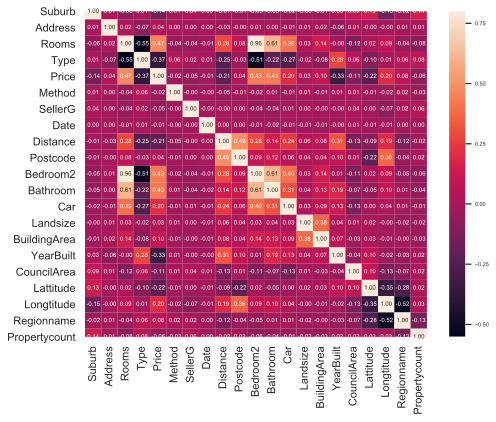

In [7]:
# SalePrice correlation matrix
corrmat = dataset.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);

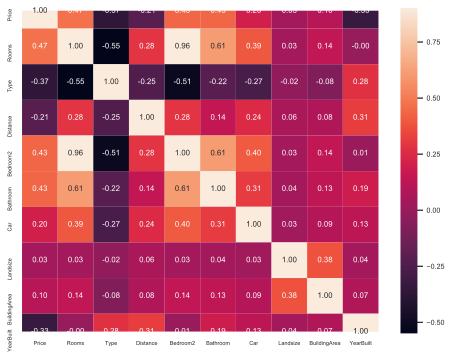

In [8]:
# choosing features to check the collinearity between them
crcols = ['Price', 'Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car','Landsize','BuildingArea', 'YearBuilt']
corrmat = dataset[crcols].corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.65)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.9);

In [9]:
'''As we can see that there is high correlation between Rooms and Bedroom2 i.e 0.96, so we will remove Bedroom2 feature'''
crcols.remove('Bedroom2')
cols = crcols
dataset = dataset[cols]
dataset.head()

,Price,Rooms,Type,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt
1,1480000.0,2,0,2.5,1.0,1.0,202.0,NaN,NaN
2,1035000.0,2,0,2.5,1.0,0.0,156.0,79.0,1900.0
4,1465000.0,3,0,2.5,2.0,0.0,134.0,150.0,1900.0
5,850000.0,3,0,2.5,2.0,1.0,94.0,NaN,NaN
6,1600000.0,4,0,2.5,1.0,2.0,120.0,142.0,2014.0


In [10]:
#Fill in null data cells using Simple Imputer
y = dataset.Price
X = SimpleImputer().fit_transform(dataset[cols])

In [11]:
#Split the data into training and validation data sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3)

# creating data frames of training and testing data
data_frame_train = pd.DataFrame(train_X)
data_frame_test = pd.DataFrame(val_X)

#Standardize the data before feeding it to PCA algorithm
scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)

#Use PCA algorithm to reduce the number of features to speed up training 
pca = PCA(.95)
pca.fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

In [12]:
#Train a model using DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [13]:
#Validate the trained model using validation data-set
cvt = cross_val_score(model, X, y)

mae = cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error')

print("Model Accuracy:\t",cvt.mean())
print("\nMean Absolute Error:\t",(-1 * mae.mean()))

Model Accuracy:	 0.9963857692841668

Mean Absolute Error:	 625.9378545751159


In [14]:
#Predict Sale Price for houses in cross validation set
predict_y = model.predict(val_X)

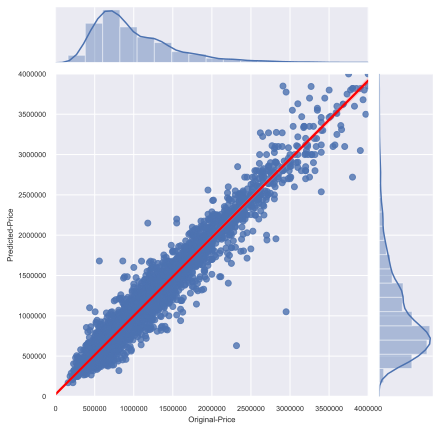

In [15]:
#Plot the actual Price value against predicted Sale Price 
g = sns.jointplot(x= val_y, y= predict_y, kind='reg', xlim=(0,4000000), ylim=(0,4000000),
                  joint_kws={'line_kws':{'color':'red'}})
g.set_axis_labels(xlabel='Original-Price', ylabel='Predicted-Price')